Import the needed packages. Most of these are fairly standard and already installed with Conda, or the like.

We also use h5py, a package for handling hdf5 format, and scikit-allel, a really handy package for reading, parsing and analyzing genomic data stored in VCF files.

In [1]:
import numpy as np
import pickle
import pandas
import matplotlib.pylab as plt
import os, sys, math
import allel; print('scikit-allel version: ', allel.__version__)
import h5py
from collections import Counter

scikit-allel version:  1.2.0


We're going to play around with the Thousand Genomes data. Here, we'll just use chromosome 22 for illustrative purposes. 

The VCF file can be found here: ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/

You want the file ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz (205 Mb)

The strict mask can be found here: ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/accessible_genome_masks/

You want 20140520.strict_mask.autosomes.bed

I placed these files in ./data/vcf and ./data/mask. If you have these to a different location, take note and change the path to each below. 

In [2]:
path_to_vcf = os.path.join('..','data','vcf')
path_to_strict_mask = os.path.join('..','data','mask')

vcf_fname = os.path.join(path_to_vcf, 'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz')
mask_fname = os.path.join(path_to_strict_mask, '20140520.strict_mask.autosomes.bed')


We'll try to read the hdf5 file, and in the case it doesn't exists we'll create it in the same directory as the vcf file (of course you can change this). If the h5 file isn't yet created, this could take a few minutes. While the h5 file is larger on disk than the compressed VCF (540 Mb), storing as hdf5 has major advantages.

In [3]:
h5_fname = os.path.join(path_to_vcf, 'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.h5')
try:
    callset = h5py.File(h5_fname, mode='r')
except OSError:
    allel.vcf_to_hdf5(vcf_fname, h5_fname, fields='*', overwrite=True)
    callset = h5py.File(h5_fname, mode='r')

Let's check out the data a bit, if we're not familiar with scikit-allel. The callset has 'calldata', which stores the genotypes 'GT'.

In [4]:
print(list(callset.keys()))
print(list(callset['calldata'].keys()))

['calldata', 'samples', 'variants']
['GT']


callset['samples'] has the names of each sample. Later we are going to filter by samples to pull out data of just a few populations, so we will filter by samples at some point.

In [5]:
callset['samples'][:10]

array(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00107'], dtype=object)

First, let's grab the genotypes and positions of every variant. Genotypes are stored as a GenotypeChunkedArray, and positions are found in callset['variants']['POS']

In [7]:
all_genotypes = allel.GenotypeChunkedArray(callset['calldata/GT'])

all_positions = callset['variants/POS'][:]

In [8]:
print('total num variants : ', len(all_positions))

total num variants :  1103547


We are going to filter this data in a few ways. Right now we have 1,103,547 variants, but not all of them are biallelic, and not all of them are SNPs. Furthermore, we're going to only keep variants that are in the 1kg strict mask.

We might also be interested in filtering out SNPs in coding regions, or only keeping intergenic variants, or only intergenic variants a given number of bp from a protein-coding gene. For now we'll just filter by the strict mask bed file, but know that filter by other features just requires generating a bed file with the regions we want to keep.

First, let's just keep variants that fall within the strict mask.

In [9]:
mask_bed = pandas.read_csv(mask_fname, sep='\t', header=None)
mask_bed = mask_bed.loc[mask_bed[0] == 'chr22']

In [10]:
n_features = mask_bed.shape[0]
in_mask = (all_positions < 0)

ii = 0
for _index, feature in mask_bed.iterrows():
    ii += 1
    if ii%5000 == 0:
        print("processed", ii, "features out of", n_features)

    start = feature[1]
    end = feature[2]
      
    in_mask = np.logical_or(in_mask, np.logical_and(all_positions>=start, 
                                                    all_positions<end))


processed 5000 features out of 55707
processed 10000 features out of 55707
processed 15000 features out of 55707
processed 20000 features out of 55707
processed 25000 features out of 55707
processed 30000 features out of 55707
processed 35000 features out of 55707
processed 40000 features out of 55707
processed 45000 features out of 55707
processed 50000 features out of 55707
processed 55000 features out of 55707


Now we'll filter both the genotypes and positions by this mask.

In [11]:
bed_genotypes = all_genotypes.compress(in_mask)
bed_positions = all_positions.compress(in_mask)

print('kept {0} of {1} variants'.format(len(bed_positions), len(all_positions)))

kept 747020 of 1103547 variants


Ok, now we're only looking at variants within our mask (I kept 747,020 out of 1,103,547, if you're keeping track). From these, let's just keep biallelic loci.

In [15]:
allele_counts = bed_genotypes.count_alleles()
is_biallelic = allele_counts.is_biallelic_01()

In [16]:
biallelic_genotypes = bed_genotypes.compress(is_biallelic)
biallelic_positions = bed_positions.compress(is_biallelic)

print('kept {0} of {1} variants'.format(len(biallelic_positions), len(bed_positions)))

kept 740759 of 747020 variants


Most were already biallelic, so we only threw out a few loci. Now we'll want to just keep loci where both the REF and ALT are A, C, G, or T (i.e. keep only SNPs, not indels or CNVs, etc).

In [17]:
alleles_to_keep = ['A','C','G','T']

refs = np.array(callset['variants/REF']).compress(in_mask).compress(is_biallelic)
alts = np.array(callset['variants/ALT'])[:,0].compress(in_mask).compress(is_biallelic)

is_snp = np.logical_and(np.isin(refs, alleles_to_keep), np.isin(alts, alleles_to_keep))

snp_genotypes = biallelic_genotypes.compress(is_snp)
snp_positions = biallelic_positions.compress(is_snp)

print('kept {0} of {1} variants'.format(len(snp_positions), len(biallelic_positions)))

kept 718653 of 740759 variants


In [18]:
allele_counts = snp_genotypes.count_alleles()

Ok, so now we have just biallelic SNPs within the strict mask for chromosome 22 (I count 718,653 of them). That wasn't too painful. I fucking love not having to read and parse a VCF file myself, that's for sure.

And now we can play around with the data a bit. Scikit-allel has some really neat features. It can easily run PCA or generate AFS, or we can compute our own LD statistics. We'll do each of these below.

First, let's just count alleles in each population, get familiar with looking at subpops.

Then we'll check out some frequency spectra. For this we'll need the population file from the Thousand Genomes (found hee : ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel). I put this file in ../data.

In [19]:
## get populations
population_file_name = '../data/integrated_call_samples_v3.20130502.ALL.panel'
samples = pandas.read_csv(population_file_name, sep='\t')

In [20]:
populations = np.array(samples['pop'].value_counts().keys())

samples.reset_index(drop=True, inplace=True)
subpops = {
    # for each population, get the list of samples that belong to the population
    pop_iter: samples[samples['pop'] == pop_iter].index.tolist() for pop_iter in populations
}

Now we can count alleles within each subpopulation.

In [21]:
ac_subpop = snp_genotypes.count_alleles_subpops(subpops)

Let's check out a few frequency spectra.

In [42]:
pops = ['YRI','CHB']
spectra = {}

for pop in pops:
    spectra[pop] = np.bincount(ac_subpop[pop][:,1])

In [43]:
import moments

for pop in pops:
    spectra[pop] = moments.Spectrum(spectra[pop]).project([80]).fold()

In [33]:
np.linspace(1,int((len(fs)-1)/2),int((len(fs)-1)/2))

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108.])

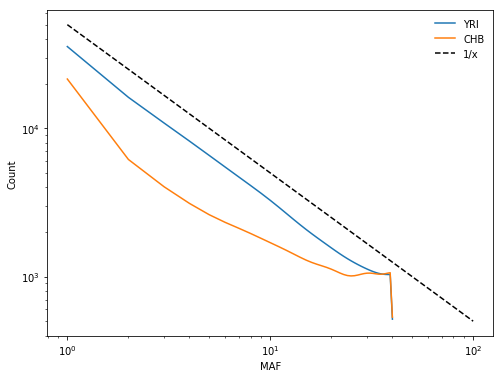

In [44]:
fig = plt.figure(figsize=(8,6))

import matplotlib.pylab as plt

for pop in pops:
    fs = spectra[pop]
    plt.plot(np.linspace(1,int((len(fs)-1)/2),int((len(fs)-1)/2)), fs[1:int((len(fs)-1)/2)+1], label=pop)


plt.plot(np.linspace(1,100,100), 50000 * np.linspace(1,100,100)**(-1), 'k--', label='1/x') # to compare to 1/x AFS
plt.legend(frameon=False)
plt.yscale('log')
plt.xscale('log')

plt.xlabel('MAF')
plt.ylabel('Count')

plt.show()

Now let's try to get some LD statistics for these populations. We'll compare $r^2$ and $\sigma_d^2$, for SNPs a given distance away. Typically I would bin pairs of SNPs based on the recombination distance between them, using a recombination map, but here I'll just bin by physical distance in base pairs.

We'll compute $r$ using the built in Rogers-Huff approach, $D^2$ and $\pi_2$ from the Hill-Robertson system, and from those we'll get $\sigma_d^2$.

Assuming that 1 cM is roughly 1 Mb, I'll keep all pairs of SNPs 100kb or less apart (roughly 0.1 cM).


XXXX we will use a recombination map

In [20]:
bin_edges = np.linspace(0.0001,0.005, 51)
bins = list(zip(bin_edges[:-1], bin_edges[1:]))
print(bin_edges)

[0.0001   0.000198 0.000296 0.000394 0.000492 0.00059  0.000688 0.000786
 0.000884 0.000982 0.00108  0.001178 0.001276 0.001374 0.001472 0.00157
 0.001668 0.001766 0.001864 0.001962 0.00206  0.002158 0.002256 0.002354
 0.002452 0.00255  0.002648 0.002746 0.002844 0.002942 0.00304  0.003138
 0.003236 0.003334 0.003432 0.00353  0.003628 0.003726 0.003824 0.003922
 0.00402  0.004118 0.004216 0.004314 0.004412 0.00451  0.004608 0.004706
 0.004804 0.004902 0.005   ]


Function to assign recombination rates to each position

In [21]:
def assign_r_pos(positions, rec_map):
    """
    Takes a rec_map, where rec_map[0] are the positions in the map, and rec_map[1] are the values
    Then returns r_value for each position in positions
    Linearly interpolates between positions in map
    """
    rs = np.zeros(len(positions))
    for ii,pos in enumerate(positions):
        if pos in np.array(rec_map[0]):
            rs[ii] = np.array(rec_map[1])[np.argwhere(pos == np.array(rec_map[0]))[0]] 
        else:
            map_ii = np.where(pos >= np.array(rec_map[0]))[0][-1]
            l = rec_map[0][map_ii]
            r = rec_map[0][map_ii+1]
            v_l = rec_map[1][map_ii]
            v_r = rec_map[1][map_ii+1]
            rs[ii] = v_l + (v_r-v_l) * (pos-l)/(r-l)
    return rs


We'll assign r-values to each position. The map I have saved here is already given in Morgans. In some cases, the map will be given in cM, which is off by a factor of 100.

In [192]:
map_file = os.path.join('..','data','maps','map_AA.chr22') # this recombination map is the African American map from Hinch et al
rec_map = pandas.read_csv(map_file, sep='\t')

map_positions = rec_map[rec_map.keys()[0]]
map_values = rec_map[rec_map.keys()[1]]

positions_r = assign_r_pos(snp_positions, [map_positions, map_values])

In [223]:
stats_to_compute = ['r2RH', 'r2', 'D2', 'pi2']

ld_stats = {}
for pop in pops:
    ld_stats[pop] = {}
    for stat in stats_to_compute:
        ld_stats[pop][stat] = np.zeros(len(bins))

total_pairs = {}
for pop in pops:
    total_pairs[pop] = np.zeros(len(bins))

We use our approach to compute $D^2$ and $\pi_2$ from genotype counts (yes, this is slow...)

In [19]:
D2cache = {}
def calc_D2(cs):
    try:
        return D2cache[tuple(cs)]
    except:
        n1,n2,n3,n4,n5,n6,n7,n8,n9 = cs
        n = sum(cs)
        numer = (n2*n4 - n2**2*n4 + 4*n3*n4 - 4*n2*n3*n4 - 4*n3**2*n4 - n2*n4**2 - 4*n3*n4**2 + n1*n5 - n1**2*n5 + n3*n5 + 2*n1*n3*n5 - n3**2*n5 - 4*n3*n4*n5 - n1*n5**2 - n3*n5**2 + 4*n1*n6 - 4*n1**2*n6 + n2*n6 - 4*n1*n2*n6 - n2**2*n6 + 2*n2*n4*n6 - 4*n1*n5*n6 - 4*n1*n6**2 - n2*n6**2 + 4*n2*n7 - 4*n2**2*n7 + 16*n3*n7 - 16*n2*n3*n7 - 16*n3**2*n7 - 4*n2*n4*n7 - 16*n3*n4*n7 + n5*n7 + 2*n1*n5*n7 - 4*n2*n5*n7 - 18*n3*n5*n7 - n5**2*n7 + 4*n6*n7 + 8*n1*n6*n7 - 16*n3*n6*n7 - 4*n5*n6*n7 - 4*n6**2*n7 - 4*n2*n7**2 - 16*n3*n7**2 - n5*n7**2 - 4*n6*n7**2 + 4*n1*n8 - 4*n1**2*n8 + 4*n3*n8 + 8*n1*n3*n8 - 4*n3**2*n8 + n4*n8 - 4*n1*n4*n8 + 2*n2*n4*n8 - n4**2*n8 - 4*n1*n5*n8 - 4*n3*n5*n8 + n6*n8 + 2*n2*n6*n8 - 4*n3*n6*n8 + 2*n4*n6*n8 - n6**2*n8 - 16*n3*n7*n8 - 4*n6*n7*n8 - 4*n1*n8**2 - 4*n3*n8**2 - n4*n8**2 - n6*n8**2 + 16*n1*n9 - 16*n1**2*n9 + 4*n2*n9 - 16*n1*n2*n9 - 4*n2**2*n9 + 4*n4*n9 - 16*n1*n4*n9 + 8*n3*n4*n9 - 4*n4**2*n9 + n5*n9 - 18*n1*n5*n9 - 4*n2*n5*n9 + 2*n3*n5*n9 - 4*n4*n5*n9 - n5**2*n9 - 16*n1*n6*n9 - 4*n2*n6*n9 + 8*n2*n7*n9 + 2*n5*n7*n9 - 16*n1*n8*n9 - 4*n4*n8*n9 - 16*n1*n9**2 - 4*n2*n9**2 - 4*n4*n9**2 - n5*n9**2)/16. + (-((n2/2. + n3 + n5/4. + n6/2.)*(n4/2. + n5/4. + n7 + n8/2.)) + (n1 + n2/2. + n4/2. + n5/4.)*(n5/4. + n6/2. + n8/2. + n9))**2
        denom = n*(n-1)*(n-2)*(n-3)
        D2cache[tuple(cs)] = 4. * numer / denom
        return D2cache[tuple(cs)]

pi2cache = {}
def calc_pi2(cs):
    try:
        return pi2cache[tuple(cs)]
    except:
        n1,n2,n3,n4,n5,n6,n7,n8,n9 = cs
        n = sum(cs)
        numer = (n1 + n2 + n3 + n4/2. + n5/2. + n6/2.)*(n1 + n2/2. + n4 + n5/2. + n7 + n8/2.)*(n2/2. + n3 + n5/2. + n6 + n8/2. + n9)*(n4/2. + n5/2. + n6/2. + n7 + n8 + n9) + (13*n2*n4 - 16*n1*n2*n4 - 11*n2**2*n4 + 16*n3*n4 - 28*n1*n3*n4 - 24*n2*n3*n4 - 8*n3**2*n4 - 11*n2*n4**2 - 20*n3*n4**2 - 6*n5 + 12*n1*n5 - 4*n1**2*n5 + 17*n2*n5 - 20*n1*n2*n5 - 11*n2**2*n5 + 12*n3*n5 - 28*n1*n3*n5 - 20*n2*n3*n5 - 4*n3**2*n5 + 17*n4*n5 - 20*n1*n4*n5 - 32*n2*n4*n5 - 40*n3*n4*n5 - 11*n4**2*n5 + 11*n5**2 - 16*n1*n5**2 - 17*n2*n5**2 - 16*n3*n5**2 - 17*n4*n5**2 - 6*n5**3 + 16*n1*n6 - 8*n1**2*n6 + 13*n2*n6 - 24*n1*n2*n6 - 11*n2**2*n6 - 28*n1*n3*n6 - 16*n2*n3*n6 + 24*n4*n6 - 36*n1*n4*n6 - 38*n2*n4*n6 - 36*n3*n4*n6 - 20*n4**2*n6 + 17*n5*n6 - 40*n1*n5*n6 - 32*n2*n5*n6 - 20*n3*n5*n6 - 42*n4*n5*n6 - 17*n5**2*n6 - 20*n1*n6**2 - 11*n2*n6**2 - 20*n4*n6**2 - 11*n5*n6**2 + 16*n2*n7 - 28*n1*n2*n7 - 20*n2**2*n7 + 16*n3*n7 - 48*n1*n3*n7 - 44*n2*n3*n7 - 16*n3**2*n7 - 24*n2*n4*n7 - 44*n3*n4*n7 + 12*n5*n7 - 28*n1*n5*n7 - 40*n2*n5*n7 - 48*n3*n5*n7 - 20*n4*n5*n7 - 16*n5**2*n7 + 16*n6*n7 - 48*n1*n6*n7 - 48*n2*n6*n7 - 44*n3*n6*n7 - 36*n4*n6*n7 - 40*n5*n6*n7 - 20*n6**2*n7 - 8*n2*n7**2 - 16*n3*n7**2 - 4*n5*n7**2 - 8*n6*n7**2 + 16*n1*n8 - 8*n1**2*n8 + 24*n2*n8 - 36*n1*n2*n8 - 20*n2**2*n8 + 16*n3*n8 - 48*n1*n3*n8 - 36*n2*n3*n8 - 8*n3**2*n8 + 13*n4*n8 - 24*n1*n4*n8 - 38*n2*n4*n8 - 48*n3*n4*n8 - 11*n4**2*n8 + 17*n5*n8 - 40*n1*n5*n8 - 42*n2*n5*n8 - 40*n3*n5*n8 - 32*n4*n5*n8 - 17*n5**2*n8 + 13*n6*n8 - 48*n1*n6*n8 - 38*n2*n6*n8 - 24*n3*n6*n8 - 38*n4*n6*n8 - 32*n5*n6*n8 - 11*n6**2*n8 - 28*n1*n7*n8 - 36*n2*n7*n8 - 44*n3*n7*n8 - 16*n4*n7*n8 - 20*n5*n7*n8 - 24*n6*n7*n8 - 20*n1*n8**2 - 20*n2*n8**2 - 20*n3*n8**2 - 11*n4*n8**2 - 11*n5*n8**2 - 11*n6*n8**2 + 16*n1*n9 - 16*n1**2*n9 + 16*n2*n9 - 44*n1*n2*n9 - 20*n2**2*n9 - 48*n1*n3*n9 - 28*n2*n3*n9 + 16*n4*n9 - 44*n1*n4*n9 - 48*n2*n4*n9 - 48*n3*n4*n9 - 20*n4**2*n9 + 12*n5*n9 - 48*n1*n5*n9 - 40*n2*n5*n9 - 28*n3*n5*n9 - 40*n4*n5*n9 - 16*n5**2*n9 - 44*n1*n6*n9 - 24*n2*n6*n9 - 36*n4*n6*n9 - 20*n5*n6*n9 - 48*n1*n7*n9 - 48*n2*n7*n9 - 48*n3*n7*n9 - 28*n4*n7*n9 - 28*n5*n7*n9 - 28*n6*n7*n9 - 44*n1*n8*n9 - 36*n2*n8*n9 - 28*n3*n8*n9 - 24*n4*n8*n9 - 20*n5*n8*n9 - 16*n6*n8*n9 - 16*n1*n9**2 - 8*n2*n9**2 - 8*n4*n9**2 - 4*n5*n9**2)/16.
        denom = n*(n-1)*(n-2)*(n-3)
        pi2cache[tuple(cs)] = 1. * numer / denom
        return pi2cache[tuple(cs)]


In [224]:
for pop in pops:
    print(pop)
    sample_list = list(callset['samples'])

    in_pop = [False]*snp_genotypes.shape[1]
    for s in samples[samples['pop'] == pop]['sample']:
        in_pop[sample_list.index(s)] = True

    pop_biallelic = ac_subpop[pop].is_biallelic()
    pop_genotypes = snp_genotypes.compress(pop_biallelic).compress(in_pop, axis=1)
    pop_genotypes_012 = pop_genotypes.to_n_alt(fill=-1)
    pop_positions = snp_positions.compress(pop_biallelic)
    pop_positions_r = positions_r.compress(pop_biallelic)

    for ii,(pos_r,g_l) in enumerate(zip(pop_positions_r,pop_genotypes_012)):
        for kk,b in enumerate(bins):
            l = b[0]
            r = b[1]
            jjs = np.logical_and(pop_positions_r-pos_r > l, pop_positions_r-pos_r <= r)
            jjs[ii] = False
            if jjs.sum() > 0:
                gs_r = pop_genotypes_012.compress(jjs)
                total_pairs[pop][kk] += len(gs_r)
                rs_RH = allel.rogers_huff_r_between([g_l],gs_r)
                ld_stats[pop]['r2RH'][kk] += np.sum(rs_RH**2)

                for g_r in gs_r:
                    counts = Counter(list(zip(g_l, g_r)))
                    cs = [counts[(2,2)], counts[(2,1)], counts[(2,0)],
                          counts[(1,2)], counts[(1,1)], counts[(1,0)],
                          counts[(0,2)], counts[(0,1)], counts[(0,0)]]
                    D2 = calc_D2(cs)
                    pi2 = calc_pi2(cs)
                    ld_stats[pop]['D2'][kk] += D2
                    ld_stats[pop]['pi2'][kk] += pi2
                    if pi2 != 0:
                        ld_stats[pop]['r2'][kk] += D2 / pi2

        if ii % 100 == 0:
            print("processed ", ii, " positions out of ", len(pop_positions))
#         if ii > 5000: # this takes a while, written in the loops like this, so we'll just look at the first 1000 SNPs
#             break


CHB
processed  0  positions out of  106537
processed  100  positions out of  106537
processed  200  positions out of  106537
processed  300  positions out of  106537
processed  400  positions out of  106537
processed  500  positions out of  106537
processed  600  positions out of  106537
processed  700  positions out of  106537
processed  800  positions out of  106537
processed  900  positions out of  106537
processed  1000  positions out of  106537
processed  1100  positions out of  106537
processed  1200  positions out of  106537
processed  1300  positions out of  106537
processed  1400  positions out of  106537
processed  1500  positions out of  106537
processed  1600  positions out of  106537
processed  1700  positions out of  106537
processed  1800  positions out of  106537
processed  1900  positions out of  106537
processed  2000  positions out of  106537
processed  2100  positions out of  106537
processed  2200  positions out of  106537
processed  2300  positions out of  106537


processed  19400  positions out of  106537
processed  19500  positions out of  106537
processed  19600  positions out of  106537
processed  19700  positions out of  106537
processed  19800  positions out of  106537
processed  19900  positions out of  106537
processed  20000  positions out of  106537
processed  20100  positions out of  106537
processed  20200  positions out of  106537
processed  20300  positions out of  106537
processed  20400  positions out of  106537
processed  20500  positions out of  106537
processed  20600  positions out of  106537
processed  20700  positions out of  106537
processed  20800  positions out of  106537
processed  20900  positions out of  106537
processed  21000  positions out of  106537
processed  21100  positions out of  106537
processed  21200  positions out of  106537
processed  21300  positions out of  106537
processed  21400  positions out of  106537
processed  21500  positions out of  106537
processed  21600  positions out of  106537
processed  

processed  38500  positions out of  106537
processed  38600  positions out of  106537
processed  38700  positions out of  106537
processed  38800  positions out of  106537
processed  38900  positions out of  106537
processed  39000  positions out of  106537
processed  39100  positions out of  106537
processed  39200  positions out of  106537
processed  39300  positions out of  106537
processed  39400  positions out of  106537
processed  39500  positions out of  106537
processed  39600  positions out of  106537
processed  39700  positions out of  106537
processed  39800  positions out of  106537
processed  39900  positions out of  106537
processed  40000  positions out of  106537
processed  40100  positions out of  106537
processed  40200  positions out of  106537
processed  40300  positions out of  106537
processed  40400  positions out of  106537
processed  40500  positions out of  106537
processed  40600  positions out of  106537
processed  40700  positions out of  106537
processed  

processed  57600  positions out of  106537
processed  57700  positions out of  106537
processed  57800  positions out of  106537
processed  57900  positions out of  106537
processed  58000  positions out of  106537
processed  58100  positions out of  106537
processed  58200  positions out of  106537
processed  58300  positions out of  106537
processed  58400  positions out of  106537
processed  58500  positions out of  106537
processed  58600  positions out of  106537
processed  58700  positions out of  106537
processed  58800  positions out of  106537
processed  58900  positions out of  106537
processed  59000  positions out of  106537
processed  59100  positions out of  106537
processed  59200  positions out of  106537
processed  59300  positions out of  106537
processed  59400  positions out of  106537
processed  59500  positions out of  106537
processed  59600  positions out of  106537
processed  59700  positions out of  106537
processed  59800  positions out of  106537
processed  

processed  76700  positions out of  106537
processed  76800  positions out of  106537
processed  76900  positions out of  106537
processed  77000  positions out of  106537
processed  77100  positions out of  106537
processed  77200  positions out of  106537
processed  77300  positions out of  106537
processed  77400  positions out of  106537
processed  77500  positions out of  106537
processed  77600  positions out of  106537
processed  77700  positions out of  106537
processed  77800  positions out of  106537
processed  77900  positions out of  106537
processed  78000  positions out of  106537
processed  78100  positions out of  106537
processed  78200  positions out of  106537
processed  78300  positions out of  106537
processed  78400  positions out of  106537
processed  78500  positions out of  106537
processed  78600  positions out of  106537
processed  78700  positions out of  106537
processed  78800  positions out of  106537
processed  78900  positions out of  106537
processed  

processed  95800  positions out of  106537
processed  95900  positions out of  106537
processed  96000  positions out of  106537
processed  96100  positions out of  106537
processed  96200  positions out of  106537
processed  96300  positions out of  106537
processed  96400  positions out of  106537
processed  96500  positions out of  106537
processed  96600  positions out of  106537
processed  96700  positions out of  106537
processed  96800  positions out of  106537
processed  96900  positions out of  106537
processed  97000  positions out of  106537
processed  97100  positions out of  106537
processed  97200  positions out of  106537
processed  97300  positions out of  106537
processed  97400  positions out of  106537
processed  97500  positions out of  106537
processed  97600  positions out of  106537
processed  97700  positions out of  106537
processed  97800  positions out of  106537
processed  97900  positions out of  106537
processed  98000  positions out of  106537
processed  

processed  8400  positions out of  103826
processed  8500  positions out of  103826
processed  8600  positions out of  103826
processed  8700  positions out of  103826
processed  8800  positions out of  103826
processed  8900  positions out of  103826
processed  9000  positions out of  103826
processed  9100  positions out of  103826
processed  9200  positions out of  103826
processed  9300  positions out of  103826
processed  9400  positions out of  103826
processed  9500  positions out of  103826
processed  9600  positions out of  103826
processed  9700  positions out of  103826
processed  9800  positions out of  103826
processed  9900  positions out of  103826
processed  10000  positions out of  103826
processed  10100  positions out of  103826
processed  10200  positions out of  103826
processed  10300  positions out of  103826
processed  10400  positions out of  103826
processed  10500  positions out of  103826
processed  10600  positions out of  103826
processed  10700  positions

processed  27500  positions out of  103826
processed  27600  positions out of  103826
processed  27700  positions out of  103826
processed  27800  positions out of  103826
processed  27900  positions out of  103826
processed  28000  positions out of  103826
processed  28100  positions out of  103826
processed  28200  positions out of  103826
processed  28300  positions out of  103826
processed  28400  positions out of  103826
processed  28500  positions out of  103826
processed  28600  positions out of  103826
processed  28700  positions out of  103826
processed  28800  positions out of  103826
processed  28900  positions out of  103826
processed  29000  positions out of  103826
processed  29100  positions out of  103826
processed  29200  positions out of  103826
processed  29300  positions out of  103826
processed  29400  positions out of  103826
processed  29500  positions out of  103826
processed  29600  positions out of  103826
processed  29700  positions out of  103826
processed  

KeyboardInterrupt: 

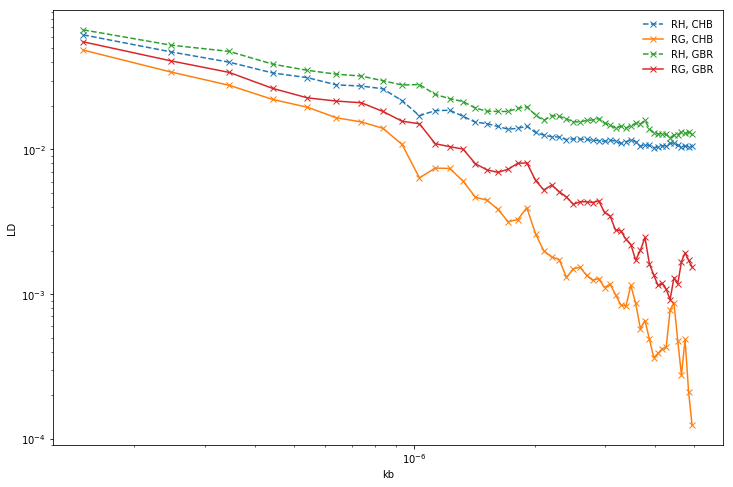

In [228]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111)

for pop in ['CHB','GBR']:
    ax.plot(np.mean(bins,axis=1)/1000., ld_stats[pop]['r2RH']/total_pairs[pop], 'x--', label='RH, {0}'.format(pop))
    ax.plot(np.mean(bins,axis=1)/1000., ld_stats[pop]['r2']/total_pairs[pop], 'x-', label='RG, {0}'.format(pop))
    #ax.plot(np.mean(bins,axis=1)/1000., ld_stats[pop]['D2'] / ld_stats[pop]['pi2'], 'o-', label='$\sigma_d^2$, {0}'.format(pop))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('kb')
ax.set_ylabel('LD')

ax.legend(frameon = False)

plt.show()

In [218]:
total_pairs

{'CHB': array([1541104.,  106607.,  151646.,  198401.,  164527.,  190725.,
         116714.,   74442.,   77708.,  128481.,   37132.,   54082.,
          39882.,   65696.,  132082.,   52748.,  227733.,   94413.,
          59218.,   53754.,  152271.,  109139.,   45001.,   35779.,
          39244.,   29074.,   20876.,   16944.,   15461.,   23764.]),
 'GBR': array([1349706.,  115385.,  147356.,  146356.,  148791.,  135788.,
         105171.,   67922.,   79169.,  151388.,   50141.,   54597.,
          39042.,   56656.,  103509.,   51787.,  208746.,   95730.,
          64149.,   58300.,  146552.,  114928.,   46329.,   36334.,
          34890.,   33870.,   21982.,   18671.,   17926.,   24809.]),
 'MXL': array([1611489.,  128396.,  179376.,  198675.,  179295.,  170958.,
         139873.,   73752.,   78342.,  138429.,   41124.,   57527.,
          42882.,   71898.,  130312.,   62935.,  243520.,  111282.,
          66802.,   64653.,  150584.,  119567.,   49317.,   40296.,
          43697.,   386

Let's compare individual $r^2$ statistics computed using HR and our approach. Take two related populations, say CHB and CDX, and compare $r^2$ haploview type plots between them

In [20]:
pop1 = 'CHB'
pop2 = 'CDX'

sample_list = list(callset['samples'])


## get the first n biallelic positions for these two pops

in_pop1 = [False]*snp_genotypes.shape[1]
in_pop2 = [False]*snp_genotypes.shape[1]

for s in samples[samples['pop'] == pop1]['sample']:
    in_pop1[sample_list.index(s)] = True

for s in samples[samples['pop'] == pop2]['sample']:
    in_pop2[sample_list.index(s)] = True

pop1_biallelic = ac_subpop[pop1].is_biallelic()
pop2_biallelic = ac_subpop[pop2].is_biallelic()

both_biallelic = np.logical_and(pop1_biallelic, pop2_biallelic)

In [37]:
start = 500
stop = 1200

n = stop-start

pop1_genotypes = snp_genotypes.compress(pop1_biallelic).compress(in_pop1, axis=1)[start:stop]
#pop2_genotypes = snp_genotypes.compress(pop1_biallelic).compress(in_pop2, axis=1)[start:stop]

In [38]:
pop1_genotypes_012 = pop1_genotypes.to_n_alt()
#pop2_genotypes_012 = pop2_genotypes.to_n_alt()

r_RH_pop1 = allel.rogers_huff_r(pop1_genotypes_012)
#r_RH_pop2 = allel.rogers_huff_r(pop2_genotypes_012)
r2_AR_pop1 = np.zeros(len(r_RH_pop1))
#r2_AR_pop2 = np.zeros(len(r_RH_pop2))

ii = 0
for i, g_l in enumerate(pop1_genotypes_012):
    for g_r in pop1_genotypes_012[i+1:]:
        counts = Counter(list(zip(g_l, g_r)))
        cs = [counts[(2,2)], counts[(2,1)], counts[(2,0)],
              counts[(1,2)], counts[(1,1)], counts[(1,0)],
              counts[(0,2)], counts[(0,1)], counts[(0,0)]]
        D2,pi2 = calc_D2(cs), calc_pi2(cs)
        if pi2 != 0:
            r2_AR_pop1[ii] = D2/pi2
        ii += 1

# ii = 0
# for i, g_l in enumerate(pop2_genotypes_012):
#     for g_r in pop2_genotypes_012[i+1:]:
#         counts = Counter(list(zip(g_l, g_r)))
#         cs = [counts[(2,2)], counts[(2,1)], counts[(2,0)],
#               counts[(1,2)], counts[(1,1)], counts[(1,0)],
#               counts[(0,2)], counts[(0,1)], counts[(0,0)]]
#         D2,pi2 = calc_D2(cs), calc_pi2(cs)
#         if pi2 != 0:
#             r2_AR_pop2[ii] = D2/pi2
#         ii += 1

In [39]:
from scipy.spatial.distance import squareform

R2s = np.zeros((n,n))
R1 = squareform(r_RH_pop1**2)
#R2 = squareform(r_RH_pop2**2)

# for i in range(n):
#     R2s[i,i+1:] = R1[i,i+1:]
#     R2s[i+1:,i] = R2[i+1:,i]

R2s_AR = np.zeros((n,n))
R1_AR = squareform(r2_AR_pop1)
#R2_AR = squareform(r2_AR_pop2)

for i in range(n):
    R2s_AR[i,i+1:] = R1_AR[i,i+1:]
#    R2s_AR[i+1:,i] = R2_AR[i+1:,i]

R2s_comp1 = np.zeros((n,n))
for i in range(n):
    R2s_comp1[i,i+1:] = R1[i,i+1:]
    R2s_comp1[i+1:,i] = R1_AR[i+1:,i]

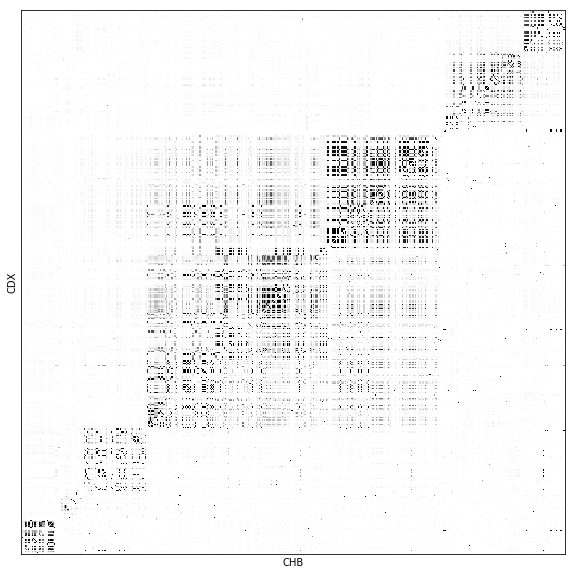

In [53]:
fig2 = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.set_aspect('equal')

ax.pcolormesh(R2s, cmap='Greys', vmin=0, vmax=1)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_xlabel(pop1);
ax.set_ylabel(pop2);

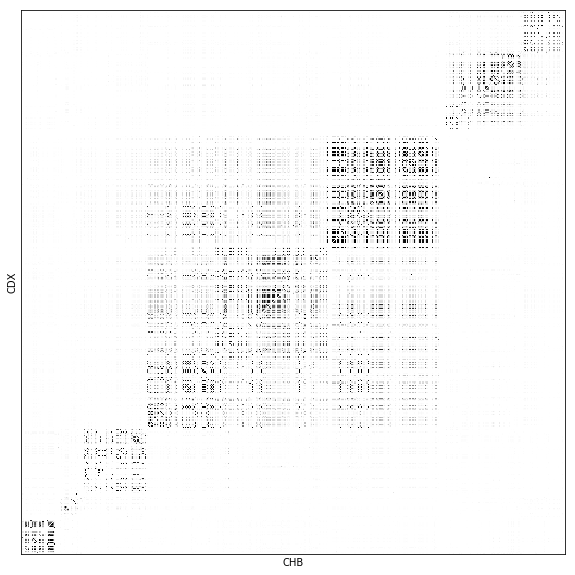

In [54]:
fig2 = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.set_aspect('equal')

pc = ax.pcolormesh(R2s_AR, vmin=0, vmax=1., cmap='Greys')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(pop1);
ax.set_ylabel(pop2);

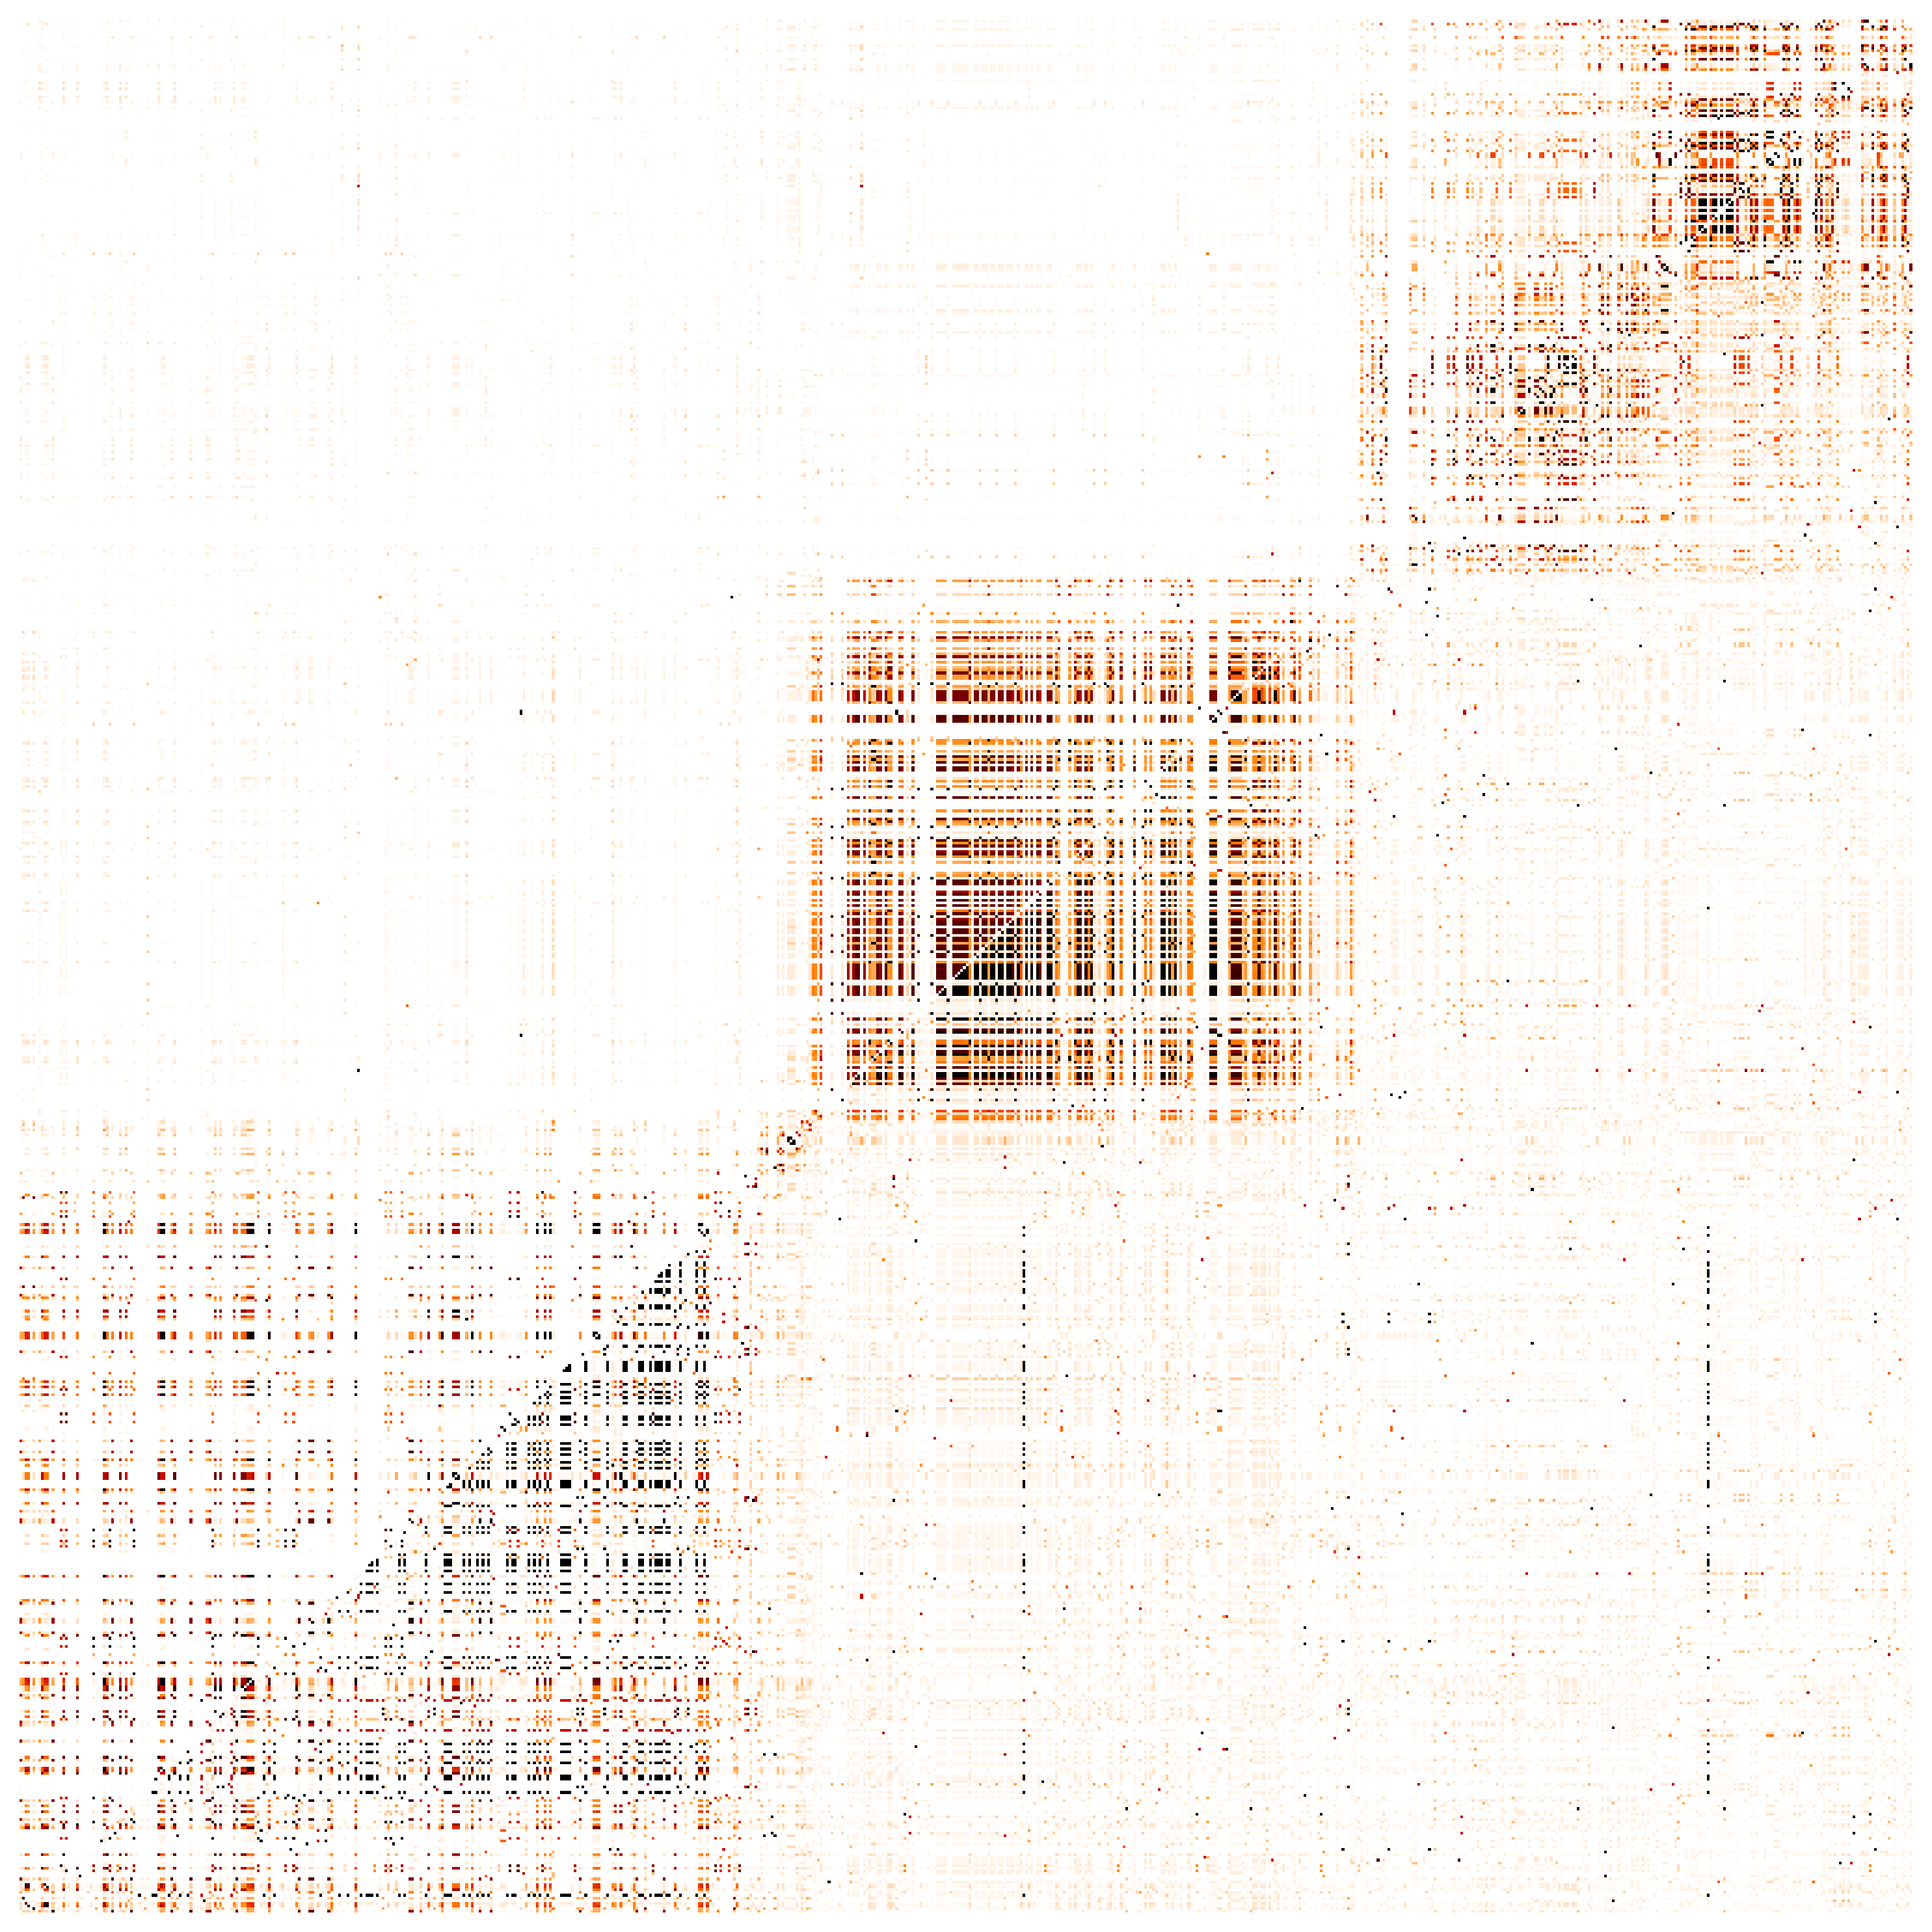

In [42]:
fig2 = plt.figure(figsize=(10,10), dpi=300)
ax = plt.subplot(111)
ax.set_aspect('equal')

R2s_comp1[R2s_comp1<0] = 0

pc = ax.pcolormesh(R2s_comp1, vmin=0, vmax=1., cmap='gist_heat_r')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xlabel('RH');
#ax.set_ylabel('AR');

ax.axis('off')

fig2.tight_layout()
plt.savefig('R2_compB.png')

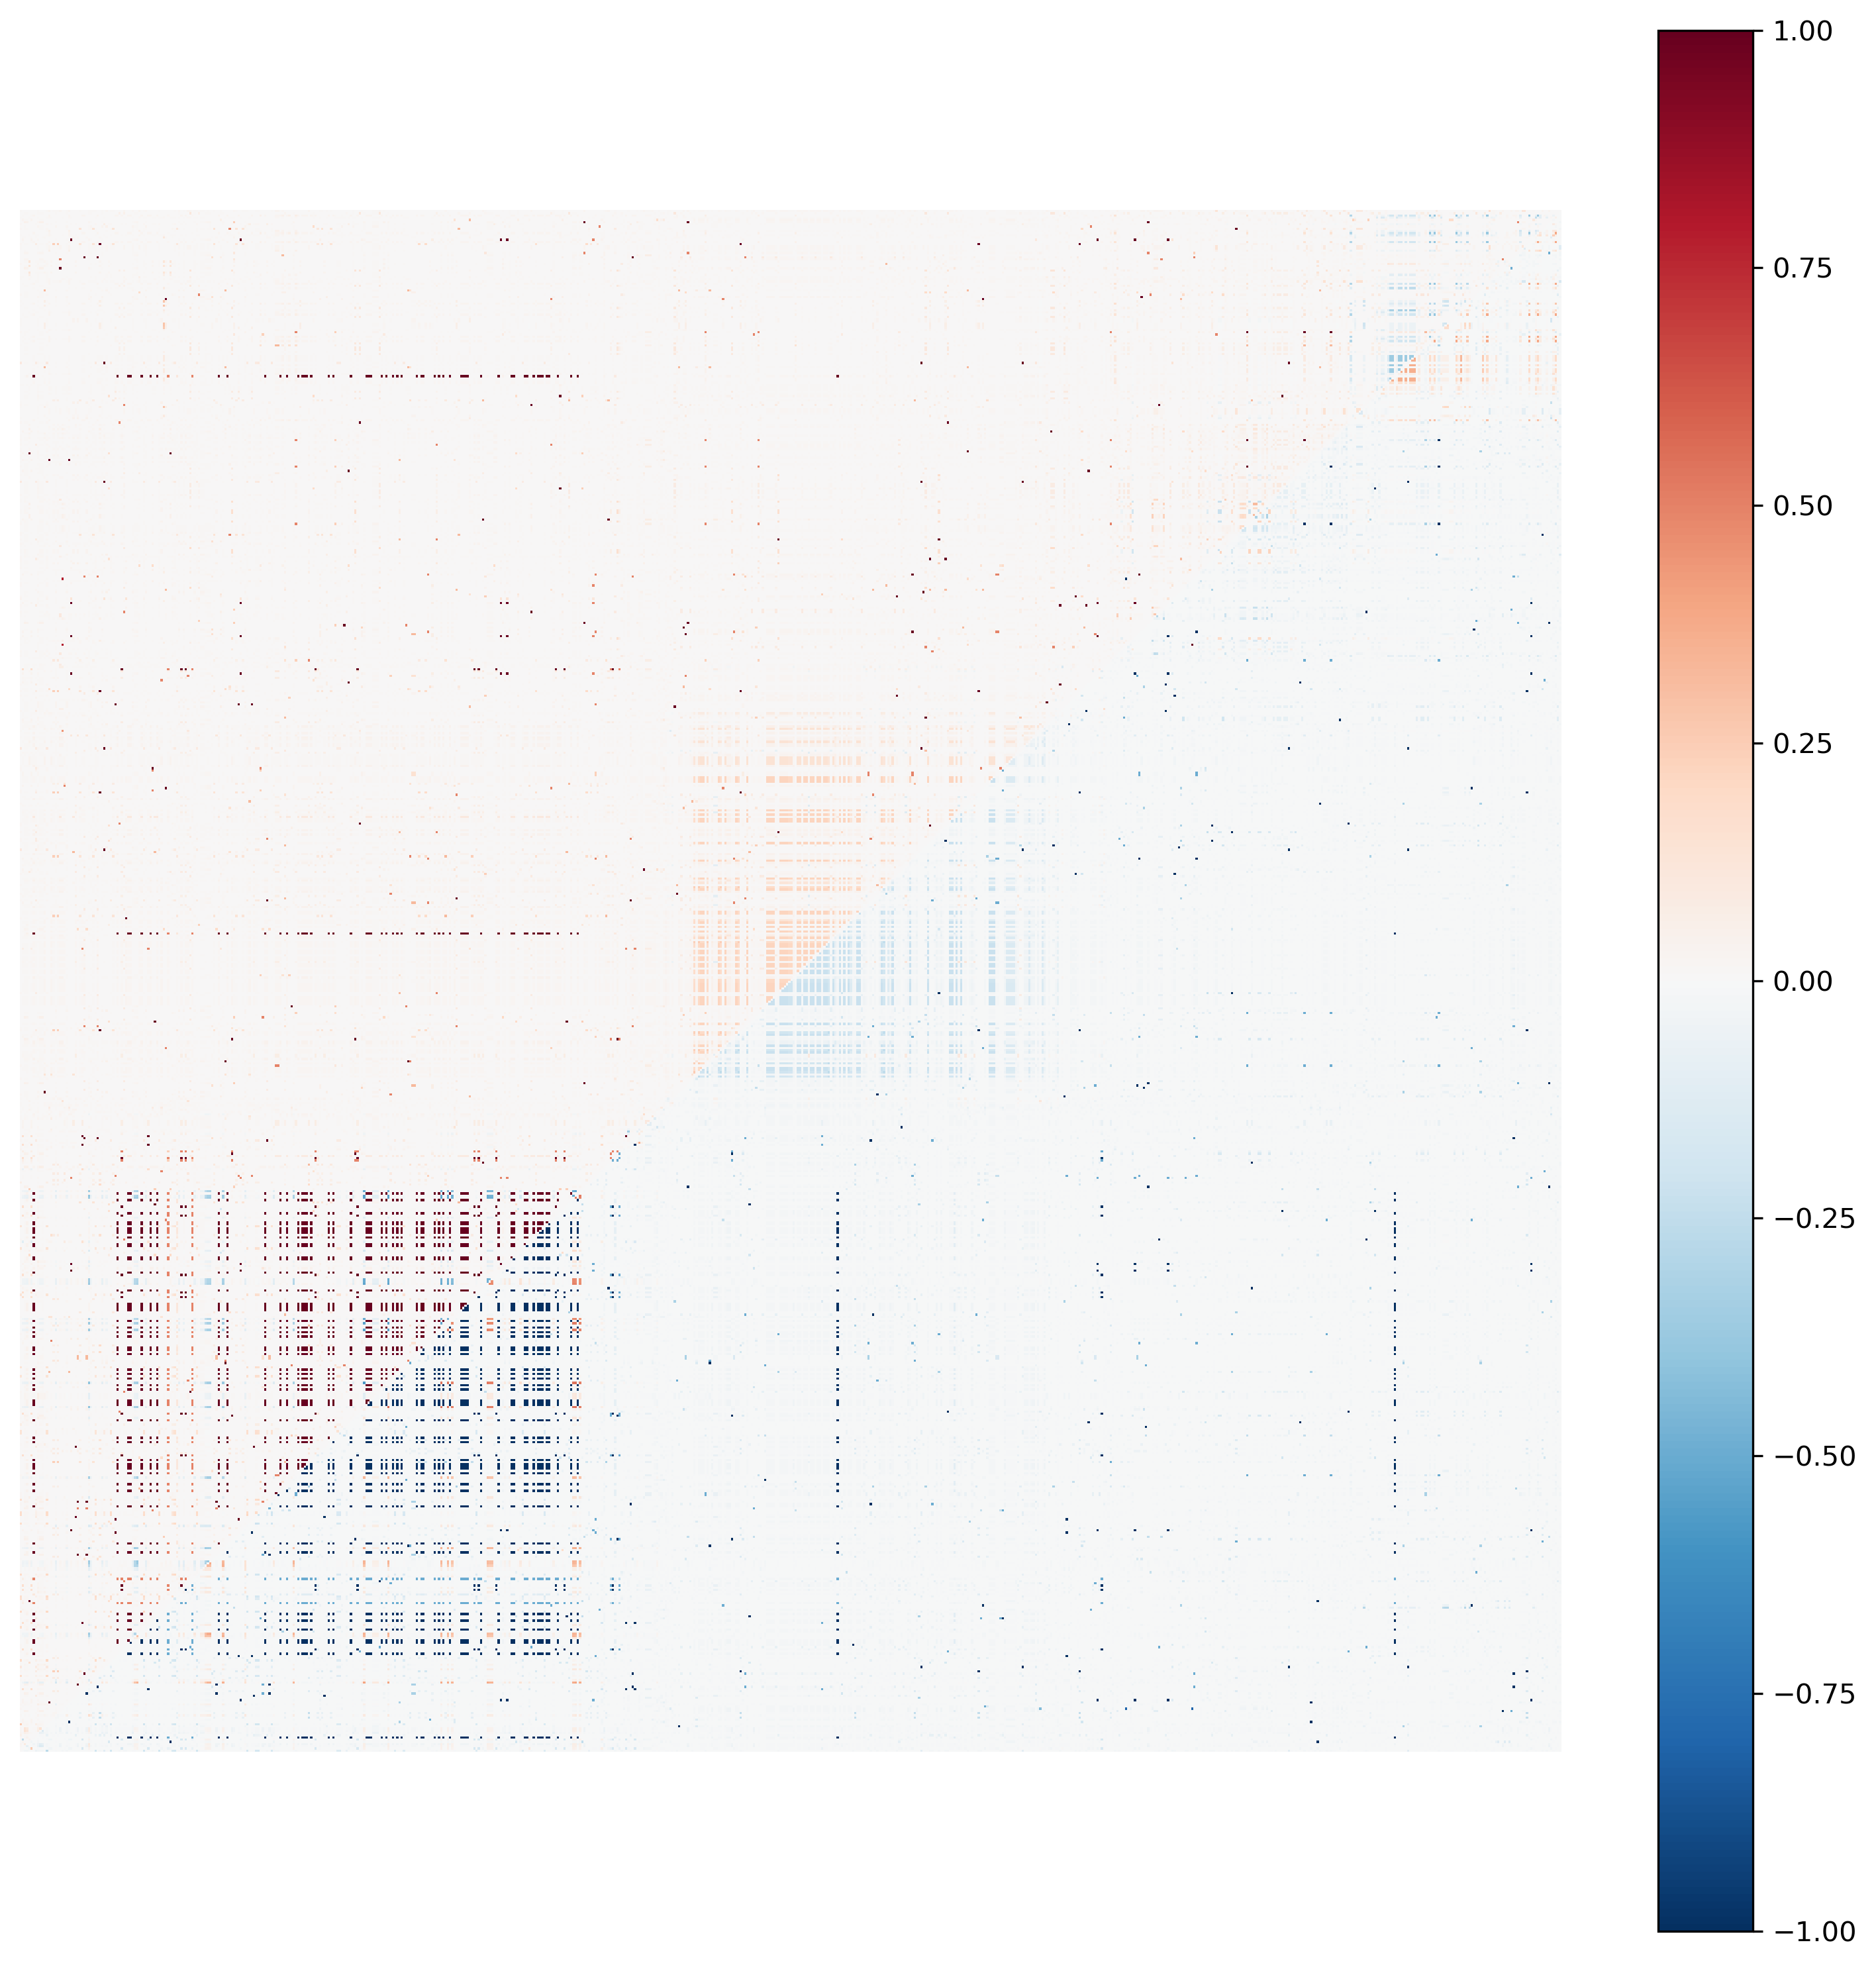

In [41]:
fig3 = plt.figure(figsize=(10,10), dpi=300)
ax = plt.subplot(111)
ax.set_aspect('equal')

resid = ax.pcolormesh((R2s_comp1 - R2s_comp1.transpose()).transpose(), vmin=-1, vmax=1., cmap='RdBu_r')

plt.colorbar(resid)

ax.set_xticks([])
ax.set_yticks([])
#ax.set_xlabel('RH');
#ax.set_ylabel('AR');

ax.axis('off')

fig3.tight_layout()



Now let's take one population, split it into a large and a small subset, and compare $r^2$ computed from each group. Rogers estimate should be quite sensitive to sample size, but ours should be a bit better.

In [55]:
pop = 'YRI'

sample_list = list(callset['samples'])

In [70]:
in_pop1 = [False]*snp_genotypes.shape[1]
in_pop2 = [False]*snp_genotypes.shape[1]

count = 0
for s in samples[samples['pop'] == pop]['sample']:
    if count < 80:
        in_pop1[sample_list.index(s)] = True
    else:
        in_pop2[sample_list.index(s)] = True
    count += 1

In [71]:
n = 500

pop_biallelic = ac_subpop[pop].is_biallelic()

In [72]:
pop1_genotypes = snp_genotypes.compress(pop_biallelic).compress(in_pop1, axis=1)[:n]
pop2_genotypes = snp_genotypes.compress(pop_biallelic).compress(in_pop2, axis=1)[:n]

In [84]:
pop1_genotypes_012 = pop1_genotypes.to_n_alt()
pop2_genotypes_012 = pop2_genotypes.to_n_alt()

r_RH_pop1 = allel.rogers_huff_r(pop1_genotypes_012)
r_RH_pop2 = allel.rogers_huff_r(pop2_genotypes_012)
r2_AR_pop1 = np.zeros(len(r_RH_pop1))
r2_AR_pop2 = np.zeros(len(r_RH_pop2))

ii = 0
for i, g_l in enumerate(pop1_genotypes_012):
    for g_r in pop1_genotypes_012[i+1:]:
        counts = Counter(list(zip(g_l, g_r)))
        cs = [counts[(2,2)], counts[(2,1)], counts[(2,0)],
              counts[(1,2)], counts[(1,1)], counts[(1,0)],
              counts[(0,2)], counts[(0,1)], counts[(0,0)]]
        D2,pi2 = calc_D2(cs), calc_pi2(cs)
        if pi2 != 0:
            r2_AR_pop1[ii] = D2/pi2
        ii += 1

ii = 0
for i, g_l in enumerate(pop2_genotypes_012):
    for g_r in pop2_genotypes_012[i+1:]:
        counts = Counter(list(zip(g_l, g_r)))
        cs = [counts[(2,2)], counts[(2,1)], counts[(2,0)],
              counts[(1,2)], counts[(1,1)], counts[(1,0)],
              counts[(0,2)], counts[(0,1)], counts[(0,0)]]
        D2,pi2 = calc_D2(cs), calc_pi2(cs)
        if pi2 != 0:
            r2_AR_pop2[ii] = D2/pi2
        ii += 1

r_RH_pop1[np.isnan(r_RH_pop1) == True] = 0
r_RH_pop2[np.isnan(r_RH_pop2) == True] = 0

In [87]:
print(np.corrcoef(r2_AR_pop1, r2_AR_pop2)[0,1])
print(np.corrcoef(r_RH_pop1, r_RH_pop2)[0,1])

0.6088076737208676
0.5052499880897956


In [88]:
from scipy.spatial.distance import squareform

R2s = np.zeros((n,n))
R1 = squareform(r_RH_pop1**2)
R2 = squareform(r_RH_pop2**2)

for i in range(n):
    R2s[i,i+1:] = R1[i,i+1:]
    R2s[i+1:,i] = R2[i+1:,i]

R2s_AR = np.zeros((n,n))
R1 = squareform(r2_AR_pop1)
R2 = squareform(r2_AR_pop2)

for i in range(n):
    R2s_AR[i,i+1:] = R1[i,i+1:]
    R2s_AR[i+1:,i] = R2[i+1:,i]


In [89]:
R2s_AR

array([[ 0.        , -0.00592596,  0.00068341, ...,  0.00438516,
         0.00399202,  0.02315703],
       [ 0.        ,  0.        , -0.00531043, ...,  0.01518595,
         0.04315904, -0.01142229],
       [ 0.        ,  0.01855093,  0.        , ...,  0.00438516,
         0.00399202,  0.02616313],
       ...,
       [ 0.        , -0.1371617 ,  0.00411946, ...,  0.        ,
         0.02561366,  0.07949408],
       [ 0.        ,  0.03783687,  0.00326264, ...,  0.00840336,
         0.        ,  0.021387  ],
       [ 0.        , -0.06277013,  0.00466429, ...,  0.12913239,
        -0.01741294,  0.        ]])

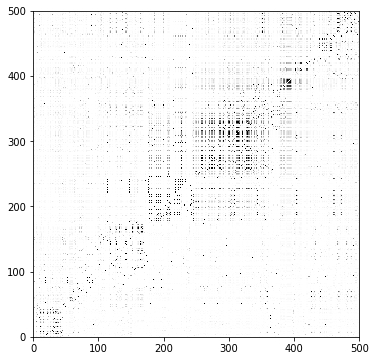

In [100]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_aspect('equal')
plt.pcolormesh(R2s, cmap='Greys', vmin=0, vmax=1)

# ax.set_xticks([]);
# ax.set_yticks([]);
# ax.set_xlabel(pop1);
# ax.set_ylabel(pop2);

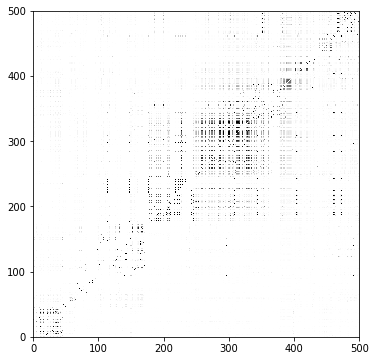

In [104]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_aspect('equal')
plt.pcolormesh(R2s_AR, cmap='Greys', vmin=0, vmax=1)
